# Vetorização de Imagens ( Image Tracing)


Importação das Bibliotecas

In [1]:
import numpy as np
np.set_printoptions(threshold=100000)   #permite printar todo o array
# Plot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import time
# Segmentação
import skimage.morphology as mm
from skimage.segmentation import watershed, join_segmentations

usadosX = []
usadosY = []

### 1. Banco de imagens
Carrega as imagens a serem segmentadas

In [2]:
triangle = np.array(Image.open('Figuras/triangle.png').convert('L'))
star     = np.array(Image.open('Figuras/star.png').convert('L'))
trapezio = np.array(Image.open('Figuras/trapezio.png').convert('L'))
brasil   = np.array(Image.open('Figuras/brasil.jpg').convert('L'))
circle   = np.array(Image.open('Figuras/circle.png').convert('L'))
# plt.imshow(, cmap='gray')

### 2. Segmentação
Função que segmenta as imagens utilizando o watershed

In [3]:
def segmentar(imagem):
    markers = np.zeros_like(imagem)
    foreground, background = 1, 2 # rótulos para as sementes (objeto = 1 e fundo = 2)
    markers[imagem > 140] = background 
    markers[imagem < 140] = foreground
    # Cálculo do watershed a partir da imagem e dos marcadores
    w1 = watershed(imagem, markers)
    return w1
#     plt.figure(1, figsize=(10,6))
#     plt.subplot(1,3,1)
#     plt.imshow(img, cmap='gray')
#     plt.title('Imagem Original')
#     plt.subplot(1,3,2)
#     plt.imshow(w1, cmap='gray')
#     plt.title('Imagem rotulada por Watershed')
#     plt.subplot(1,3,3)
#     plt.imshow(mark_boundaries(img,w1))
#     plt.title('Imagem segmentada - linha de watershed')

### 3. Algoritmo para detecção das formas básicas (retas/curvas)

As funçoes abaixo compoem o algoritmo de detecção de formas basicas.  A função de busca utiliza recursão, que baseado no quadrante atual onde o pixel se encontra, faz uma busca pelo proximo pixel. Se o proximo pixel for encontrado, o algoritmo utiliza a função polyfit para deteminar se ele deve fazer parte do segmento. Quando todos os pixels no quadrante foram buscados, a função retorna o segmento criado.


In [4]:
# em w1, imagem com o watershed ja:
# 1 = branco
# 2 = preto


# dependendo de qual tipo de curva vc quer basta chamar uma das quatro


def check_for_anormalities(segmentoX): # checa se há uma anomalia, ou seja, se há pontos alinhados que não são bem tratrados pelo fit
        for i in range(0, segmentoX.size):
            if segmentoX[i] != segmentoX[i - 1]:
                return 0
        return 1
                
def checa_limite(x, y, segmentoX, segmentoY):
    # checa se existem pelo menos 3 pontos no vetor pra poder fazer a checagem
    if(len(segmentoX) >= 3):
        f = np.polyfit(segmentoX, segmentoY, 2)
        f = np.poly1d(f)
        
        line = check_for_anormalities(segmentoX)
        if line == 1: # se todos os pontos estão alinhados pode inserir
            return 1
        else:
            error = np.power(y - f(x),2)
            if(error > 8):
                return 0 # se o erro for maior que o threshold, retorna 0 e não permite que a inserção seja feita
            else: 
                return 1
    else:
        return 1

def busca(x, y, w1, segmentoX, segmentoY, quadrante):
    found_pixel = 0    
    if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmentoX, segmentoY, x, y)): # pixel diretamente à direita em cima
        segmentoX = np.append(segmentoX,x)
        segmentoY = np.append(segmentoY,y)
        
        usadosX.append(x)
        usadosY.append(y)
        
        found_pixel = 1
        
        
        if(quadrante == 1):
            segmentoX,segmentoY = busca_primeiro_quadrante(x,y,w1,segmentoX,segmentoY)
        elif(quadrante == 2):
            segmentoX, segmentoY = busca_segundo_quadrante(x, y, w1, segmentoX, segmentoY)
        elif(quadrante == 3):
            segmentoX, segmentoY = busca_terceiro_quadrante(x, y, w1, segmentoX, segmentoY)
        else:
            segmentoX, segmentoY = busca_quarto_quadrante(x, y, w1, segmentoX, segmentoY)
             
    return segmentoX, segmentoY, found_pixel


def busca_primeiro_quadrante(x,y,w1,segmentoX,segmentoY): 
    segmentoXTemp = segmentoX
    segmentoYTemp = segmentoY
    ultimo = np.size(segmentoXTemp) - 1
    
    segmentoX, segmentoY,f_p = busca(x - 1, y, w1, segmentoX, segmentoY, 1)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y + 1, w1, segmentoX, segmentoY, 1)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x , y + 1, w1, segmentoX, segmentoY, 1)
    return segmentoX,segmentoY

def busca_segundo_quadrante(x,y,w1,segmentoX,segmentoY): 
    segmentoX, segmentoY,f_p = busca(x, y - 1, w1, segmentoX, segmentoY, 2)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y - 1, w1, segmentoX, segmentoY, 2)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y , w1, segmentoX, segmentoY, 2)
    return segmentoX,segmentoY

def busca_terceiro_quadrante(x,y,w1,segmentoX, segmentoY):
    segmentoX, segmentoY,f_p = busca(x + 1, y, w1, segmentoX, segmentoY, 3)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1, y - 1, w1, segmentoX, segmentoY, 3)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x , y - 1, w1, segmentoX, segmentoY, 3)
    return segmentoX,segmentoY

def busca_quarto_quadrante(x,y,w1,segmentoX, segmentoY):
    segmentoX, segmentoY,f_p = busca(x, y + 1, w1, segmentoX, segmentoY, 4)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1, y + 1, w1, segmentoX, segmentoY, 4)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1 , y , w1, segmentoX, segmentoY, 4)

    return segmentoX,segmentoY

### Checa se o pixel já foi inserido

In [5]:
def checa_ja_inserido(segmento_x, segmento_y, x, y): 
    for i in range(0, len(usadosX)):
        if(usadosX[i] == x and usadosY[i] == y):
            return 1
    # se o ponto já tiver sido inserido nesse ponto já retornou um 1, se não retorna 0 e sabemos que não pegamos o ponto ate agora
    return 0
    

### 4.Plotar as formas
A função abaixo executa a vetorização. Inicialmente, o algoritmo busca um pixel na borda,e a partir do primeiro pixel a busca por segmentos se inicia. A função termina quando atinge o limite para quantos segmentos a imagem deve criar, ou quando o ultimo pixel do novo segmento alcança o primeiro pixel do primeiro segmento.

Por fim, as imagens segmentadas são plotadas, com a segmentação em destaque.

In [6]:
# plt.figure(1, figsize=(16,7))

# fig, ax = plt.subplot(1,2,1)
# plt.imshow(img, cmap='gray')
# plt.title('Imagem Original')

# plt.subplot(1,2,2)

def vetorizar(imagem, time_step):
    
    w1 = segmentar(imagem)
    # Inicialização do plot
    %matplotlib notebook
    fig = plt.figure(2, figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.clear()
    plt.ion()
    fig.show()
    fig.canvas.draw()

    # plt.imshow(img, cmap='gray')

    ax.imshow(w1, cmap='gray')

    ##################################

    segmentoX = []
    segmentoY = []
    usadosX.clear()
    usadosY.clear()
    fit = []

    #limite de seguimentos
    limite_seg = 50;

    #achar as bordas de um segmento 1ª borda
    for t in range(0, w1.shape[1]): # varre em x
        for s in range(0, w1.shape[0]): # varre em y
            if(w1[t,s] != 2): # achou o primeiro pixel da borda
    #             print(t,s)
                segmentoX.insert(0, np.array([t]))
                segmentoY.insert(0, np.array([s]))
                break

        if(w1[t,s] != 2):
                 break            


    segmentoX[0], segmentoY[0] = busca_primeiro_quadrante(t, s, w1, segmentoX[0], segmentoY[0])
    last_quadrant = 1
    if(segmentoX[0].size == 1):
        last_quadrant = 4
        segmentoX[0], segmentoY[0] = busca_quarto_quadrante(t, s, w1, segmentoX[0], segmentoY[0])

        if(segmentoX[0].size == 1):
            last_quadrant = 3
            segmentoX[0], segmentoY[0] = busca_terceiro_quadrante(t, s, w1, segmentoX[0], segmentoY[0])
            if(segmentoX[0].size == 1):       
                segmentoX[0], segmentoY[0] = busca_segundo_quadrante(t, s, w1, segmentoX[0], segmentoY[0])
                last_quadrant = 2



    # Calcula o Fit do segmento 0
    fit.insert(0, np.poly1d( np.polyfit(segmentoY[0], segmentoX[0], 1) ))
    # Plota o Segmento 0
    ax.plot(segmentoY[0], fit[0](segmentoY[0]),  'b-', color='red',  linewidth=4)
    fig.canvas.draw()
    # plt.gca().invert_yaxis()
    time.sleep(time_step)
    flag_novosegmento = 0
    novo_x = 0
    novo_y = 0
    i = 1

    while True:
        # seta os limites do plot conforme a figura original
        ax.set(xlim=(0, imagem.shape[1]), ylim=(0, imagem.shape[0]))
        plt.gca().invert_yaxis()

        # Verifica se o segmento feito ja nao existe checando o primeiro pixel dos 2 ultimos
        # Se existir, pular para um proximo pixel
        if(segmentoX[i-2][0] == segmentoX[i-1][0] and segmentoY[i-2][0] == segmentoY[i-1][0] and i > 2):
            #print(segmentoX[i-2], segmentoX[i-1])
            for k in range(0, (w1.shape[1])-1):
                for j in range(0, (w1.shape[0])-1):
                    if(w1[j,k] != 2):
                        if(not checa_ja_inserido(segmentoX, segmentoY, j, k)):
                            flag_novosegmento = 1 #aciona a flag dizendo pra comecar a partir de outro pixel
                            novo_x = j
                            novo_y = k
                            break

        # pega o último píxel utilizado para começar o próximo segmento
        last_pixel = (segmentoX[i-1][-1], segmentoY[i-1][-1])
        if(flag_novosegmento == 1):
            flag_novosegmento = 0
            last_pixel = (novo_x, novo_y)

        segmentoX.insert( i, [last_pixel[0]])    # Segmento[i]
        segmentoY.insert( i, [last_pixel[1]])

        # utilizando last quadrante podemos saber qual foi o quadrante de que viemos, evitando voltarmos no segmento
        if(last_quadrant != 1):    
            segmentoX[i], segmentoY[i] = busca_primeiro_quadrante(last_pixel[0], last_pixel[1], w1, segmentoX[i], segmentoY[i])
            last_quadrant = 1

        if(len(segmentoX[i]) == 1 and last_quadrant != 4):
            last_quadrant = 4
            segmentoX[i], segmentoY[i] = busca_quarto_quadrante(last_pixel[0], last_pixel[1], w1, segmentoX[i], segmentoY[i])

        if(len(segmentoX[i]) == 1 and last_quadrant != 3):
            last_quadrant = 3
            segmentoX[i], segmentoY[i] = busca_terceiro_quadrante(last_pixel[0], last_pixel[1], w1, segmentoX[i], segmentoY[i])

        if(len(segmentoX[i]) == 1 and last_quadrant != 2):
            segmentoX[i], segmentoY[i] = busca_segundo_quadrante(last_pixel[0], last_pixel[1], w1, segmentoX[i], segmentoY[i])
            last_quadrant = 2

        # Calcula o Fit do segmento i
        fit.insert(i, np.poly1d( np.polyfit(segmentoY[i], segmentoX[i], 1) ))

        # Plota o Segmento i
    #     ax.clear()
        ax.plot(segmentoY[i], fit[i](segmentoY[i]),  'b-', color='red',  linewidth=4)
        fig.canvas.draw()
        time.sleep(time_step)

        #  Condiçao de parada - quando o ultimo ponto do segmento retornou ao ponto inicial
        if(segmentoX[i][-1] == t and segmentoY[i][-1] == s):
            print("Segmentação Completa")
            print(i+1, "segmentos")
            break

        #  Condiçao de parada para quando nao conseguir terminar 
        if(i > limite_seg):
            print("Segmentação Incompleta")
            print(i+1, "segmentos")
            break

        i = i + 1


    # plt.title('Versao Vetorizada')

<IPython.core.display.Javascript object>


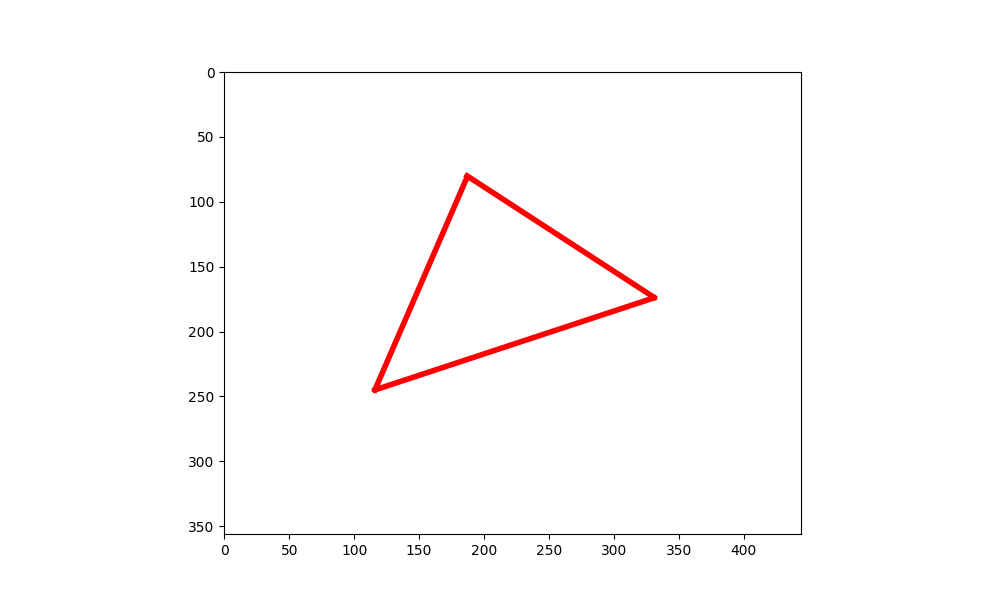

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned


Segmentação Completa
3 segmentos


In [7]:
vetorizar(triangle, 1)

<IPython.core.display.Javascript object>


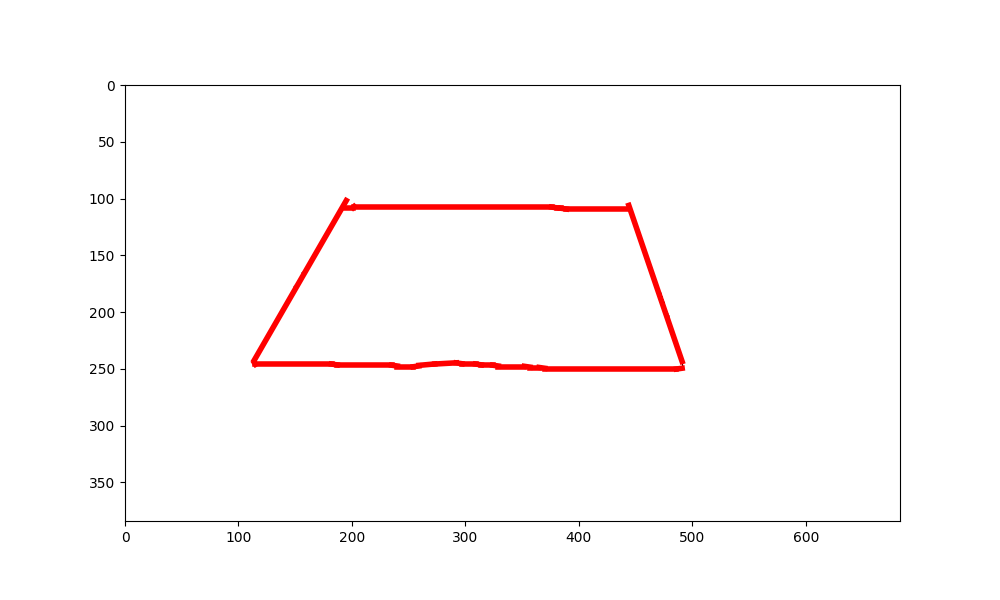

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

Segmentação Completa
29 segmentos


In [14]:
vetorizar(trapezio, 0.1)

<IPython.core.display.Javascript object>


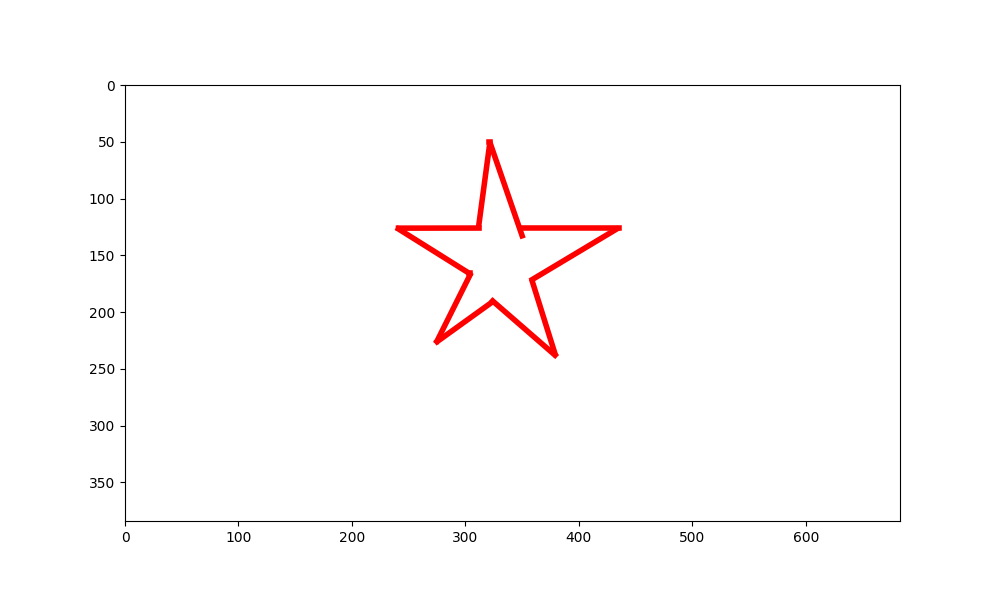

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: 

Segmentação Completa
15 segmentos


In [13]:
vetorizar(star, 0.1)

<IPython.core.display.Javascript object>


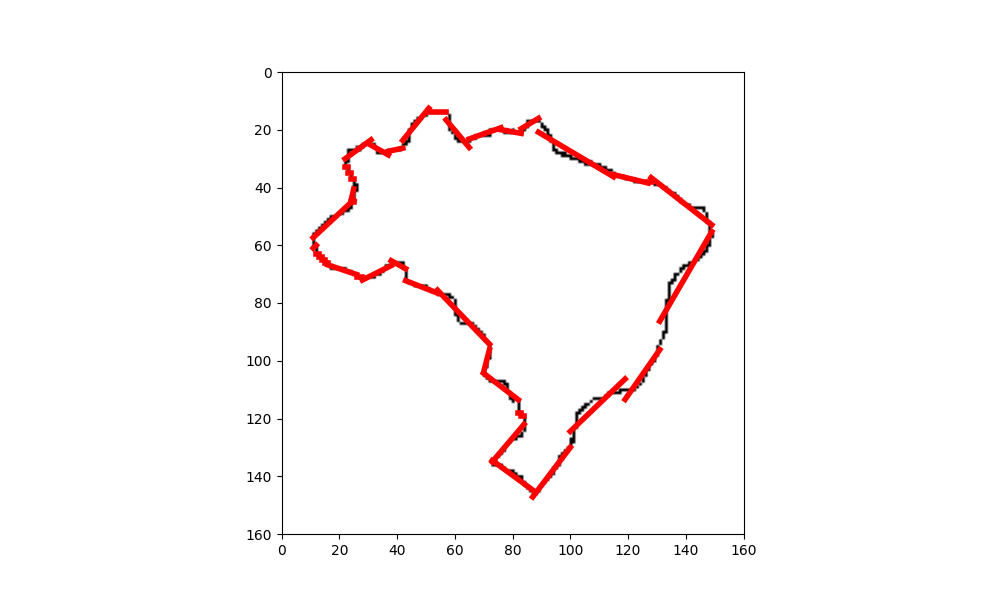

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

Segmentação Completa
52 segmentos


In [12]:
vetorizar(brasil, 0.06)

<IPython.core.display.Javascript object>


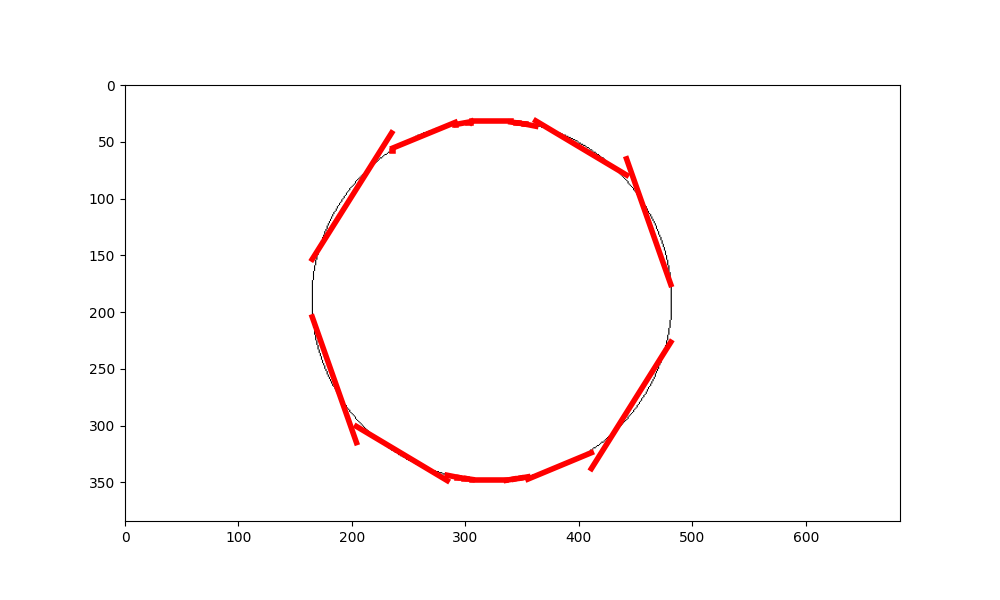

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RankWar

Segmentação Completa
28 segmentos


In [15]:
vetorizar(circle, 0.1)